In [23]:
import pandas as pd
import numpy as np
import pickle
from nltk import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import product
import os
import sklearn.metrics as mt
import time
import math
from random import shuffle

POS = ['MD', 'VBN', 'PRP$', 'CD', 'NNS', 'RBR', 'LS', 'WP', 'JJR', 'RB', 'WP$', 'VBZ', '-LRB-', 'CC', 'JJ', '$', ':', 'VBG', "''", ',', 'WDT', 'EX', 'PDT', 'RP', '``', 'NNPS', 'NNP', 'FW', 'VB', 'PRP', 'RBS', 'DT', 'WRB', 'NN', '.', '-NONE-', 'IN', 'TO', 'UH', 'VBD', 'POS', 'VBP', 'JJS', 'SYM', '(', ')']

In [24]:
file_name = 'sentences'

In [82]:
#get tfidf of n-grams

import snowballstemmer
english_stemmer = snowballstemmer.stemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))
     
StemmedTfidfVectorizer(min_df=1, stop_words='english', analyzer='word', ngram_range=(1,1))

def getNgram(data, n):
    tfidf_vect = StemmedTfidfVectorizer(min_df=1, stop_words='english', analyzer='word', ngram_range=(n,n))
#     TfidfVectorizer(min_df=1, ngram_range=(n,n), stop_words='english')
    sentence_term_tfidf = tfidf_vect.fit_transform(data.text)
    sentence_term_df = pd.DataFrame(sentence_term_tfidf.todense(), columns=np.sort(list(tfidf_vect.vocabulary_.keys())))
    pd.DataFrame(sentence_term_df.columns).to_csv("models/vocabulary_"+file_name+".txt", encoding='utf-8', index=False)    
    sentence_term_df.columns = sentence_term_df.columns.map(lambda x: 'W_'+str(n)+'_'+x)
    pickle.dump(tfidf_vect.idf_, open( "models/idf_"+file_name, "wb" )) #storing the vocabulary    
    return sentence_term_df

In [26]:
#get POS count of n-grams
def getPOS(data, n):
	POSn = {x:0 for x in product(POS, repeat=n)}
	data_pos = pd.DataFrame(columns=POSn.keys())
	data_pos.columns = data_pos.columns.map(lambda x: 'P_'+str(n)+'_'+'_'.join(x) )
	for idx,text in enumerate(data.text):
		POSn = {x:0 for x in product(POS, repeat=n)}
		token_pos = pos_tag(nltk.word_tokenize(text))
		token_pos = [y for (x,y) in token_pos]
		token_pos = zip(*[token_pos[i:] for i in range(n)])
		for tp in token_pos:
			POSn[tp] += 1
		data_pos.loc[idx] = list(POSn.values())
	return data_pos

In [27]:
#get engineered features
def getFE(data=None):
    patterns = [r'^.*(percent|times|\%).* of .*$', 
               r'^(?!.*think|.*believe).*(more|less|lower|higher|bigger|smaller|increasing|decreasing).* than .*$',
               r'^(?!.*think|.*believe).*( increas| decreas).*$',
               r'^.*[0-9]+ (to|or|and) [0-9]+.*$',
               r'^.*there.*(is|was|are|has|had).*(never|not).*$',
               r'^.*(support|oppose).*(abortion|tax|right|civil|China|wage|gun|global|immigration|health|security|energy|care).*$']
    data_fe = pd.DataFrame(columns=range(len(patterns)))
    data_fe.columns = data_fe.columns.map(lambda x: 'FE'+'_'+str(x) )
    for i, pattern in enumerate(patterns):
        data_fe['FE_'+str(i)] = data.text.str.contains(pattern)
    return data_fe

In [28]:
#Train models with data and store models as pickle objects
def trainModels(data, clfs, features, labels):
	models = []
	for feature_regex, feature_types in features:
		for clf, name in clfs:
			clf.fit(data.filter(regex=feature_regex), data[labels])
			j = joblib.dump(clf, 'models/'+name+'_'+feature_types+'_'+file_name+'.pkl')
			models += [(name, (feature_regex, feature_types), clf)]
			print (name+'_'+feature_types+" complete")
	return models

In [29]:
def evaluate(data, clfs, features, labels, fold):    
    a = list(data[labels])
    b = [0]*np.unique(data[labels])
    mask = [0]*len(a)
    for i in range(len(a)):
        if a[i] == -1:
            mask[i] = b[0]
            b[0] = (b[0]+1)%fold
        elif a[i] == 0:
            mask[i] = b[1]
            b[1] = (b[1]+1)%fold
        elif a[i] == 1:
            mask[i] = b[2]
            b[2] = (b[2]+1)%fold
    data.loc[:,'msk'] = pd.Series(mask, index=data.index)
    
    for feature_regex, feature_types in features:        
        for clf, name in clfs:
            print('##########'+name+'###'+feature_types+'#######')
            precision, recall, f1, kappa_value, prf_w, cm = np.zeros((1,len(np.unique(data[labels])))), np.zeros((1,len(np.unique(data[labels])))), np.zeros((1,len(np.unique(data[labels])))), 0, np.zeros((1,3)), np.zeros((3,3)) #, roc_auc = np.zeros((1,len(np.unique(data_regex.verdict))))
            for i in range(fold):
                train = data.loc[data.msk != i]
                test = data.loc[data.msk == i]
                clf.fit(train.filter(regex=feature_regex), train[labels])

                prediction = clf.predict(test.filter(regex=feature_regex))                
                print('##########Classification Report##########')
                print(mt.classification_report(test[labels], prediction))
                print('##########Confusion Matrix##########')
                cm += mt.confusion_matrix(test[labels], prediction)
                print(mt.confusion_matrix(test[labels], prediction))
                print('')

                precision += mt.precision_score(test[labels], prediction, average=None)
                recall += mt.recall_score(test[labels], prediction, average=None)
                f1 += mt.f1_score(test[labels], prediction, average=None)
                prf_w += mt.precision_recall_fscore_support(test[labels], prediction, average='weighted')[0:3]

            precision /= fold
            recall /= fold
            f1 /= fold
            prf_w /= fold
            print('##########Overall Confusion Matrix##########')
            print(cm)

In [83]:
data = pd.read_csv('./'+file_name+'.csv', encoding='utf-8')
data = data.rename(columns = {'verdict':'label'})
data = pd.concat([data, getNgram(data, 1)], axis = 1)
data = pd.concat([data, getPOS(data, 1)], axis = 1)
#data = pd.concat([data, getFE(data)], axis = 1)
j = joblib.dump(data, './models/DF_'+file_name+'.pkl')

In [92]:
data.shape

(17662, 6594)

In [30]:
data = joblib.load('./models/DF_'+file_name+'.pkl')

In [84]:
clfs = [(LinearSVC(), "SVM")]
features = [('W_1|P_1', 'W_1_P_1')]

In [85]:
models = trainModels(data, clfs, features, 'label')

SVM_W_1_P_1 complete


In [86]:
evaluate(data, clfs, features, 'label', 4)

##########SVM###W_1_P_1#######
##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.83      0.92      0.87      2962
          0       0.48      0.23      0.31       407
          1       0.69      0.62      0.66      1047

avg / total       0.76      0.78      0.77      4416

##########Confusion Matrix##########
[[2719   51  192]
 [ 219   93   95]
 [ 346   49  652]]

##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.82      0.92      0.87      2962
          0       0.46      0.18      0.26       407
          1       0.69      0.62      0.66      1047

avg / total       0.76      0.78      0.76      4416

##########Confusion Matrix##########
[[2723   50  189]
 [ 227   75  105]
 [ 354   39  654]]

##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.83      0.91      0.87      2962
          0   

In [34]:
def overfitDetect():
    for x in range(1,6):
        frac = 2.0*x/10.0
        data_sample = data.sample(frac=frac)
        print("######### Sample Size "+str(frac)+" #########")
        models = trainModels(data_sample, clfs, features, 'label')
        evaluate(data_sample, clfs, features, 'label', 4)

In [35]:
overfitDetect()

######### Sample Size 0.2 #########
SVM_W_1_P_1 complete
##########SVM###W_1_P_1#######
##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.82      0.91      0.86       592
          0       0.46      0.23      0.31        82
          1       0.65      0.60      0.62       210

avg / total       0.75      0.77      0.75       884

##########Confusion Matrix##########
[[536  10  46]
 [ 43  19  20]
 [ 73  12 125]]

##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.81      0.92      0.86       592
          0       0.51      0.22      0.31        82
          1       0.67      0.56      0.61       209

avg / total       0.75      0.77      0.75       883

##########Confusion Matrix##########
[[542   7  43]
 [ 48  18  16]
 [ 81  10 118]]

##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.81      

In [42]:
data_nfs = data.loc[data['label'] == -1]
data_ufs = data.loc[data['label'] == 0]
data_cfs = data.loc[data['label'] == 1]
data_nfs_sample = data_nfs.sample(frac=0.5)
data_uniform = pd.concat([data_nfs_sample, data_ufs, data_cfs])
print (data_uniform.shape)
models = trainModels(data_uniform, clfs, features, 'label')
evaluate(data_uniform, clfs, features, 'label', 4)

(11738, 10561)
SVM_W_1_P_1 complete
##########SVM###W_1_P_1#######
##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.77      0.86      0.81      1481
          0       0.49      0.34      0.40       407
          1       0.73      0.71      0.72      1047

avg / total       0.72      0.73      0.72      2935

##########Confusion Matrix##########
[[1271   60  150]
 [ 148  138  121]
 [ 223   81  743]]

##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.76      0.85      0.80      1481
          0       0.53      0.31      0.40       407
          1       0.73      0.73      0.73      1047

avg / total       0.72      0.73      0.72      2935

##########Confusion Matrix##########
[[1258   56  167]
 [ 159  128  120]
 [ 231   56  760]]

##########Classification Report##########
             precision    recall  f1-score   support

         -1       0.77      0.8

In [4]:
def getPOSVector(text):
	dict_pos_count = {k:0 for k in POS}
	pos_tags = pos_tag(word_tokenize(text))# TextBlob(text).pos_tags# 
	for word, tag in pos_tags:
		if tag in dict_pos_count.keys():
			dict_pos_count[tag] += 1
	return dict_pos_count

In [5]:
#get CFS score of a text
def getCFSScore(transcript="", tokenize_sentence = False, models=[("SVM", ("W_1|P_1", "W_1_P_1"), None)]):
    vocabulary = pd.read_csv(os.path.join('models', 'vocabulary.txt'))
    count_vect = CountVectorizer(vocabulary=vocabulary['0'])
    idf_ = pickle.load(open(os.path.join('models', 'idf_'),'rb'))

    if tokenize_sentence:
        sentences = sent_tokenize(transcript)
    else:
        sentences = [transcript]
    sentences = pd.DataFrame(sentences)
    sentences.columns = ['text']
    sentences['original_text'] = sentences.text
    sentences.text = sentences['original_text'].map( lambda s: s.lower() )
    sentences['sentence_id'] = sentences.index

    sentence_word = count_vect.fit_transform(sentences.text)
    sentence_word = sentence_word.toarray() * idf_
    sentence_word = normalize(sentence_word, axis = 1, norm='l2')

    sentence_word = pd.DataFrame(sentence_word, columns=vocabulary['0'])
    sentence_word = pd.concat([sentences.sentence_id, sentence_word], axis = 1)
    sentence_word = sentence_word.set_index('sentence_id')
    sentence_word.columns = sentence_word.columns.map(lambda x: 'W_1_'+str(x))
        
    sentence_pos = {sentences.sentence_id[i]:getPOSVector(sentences.text[i]) for i in sentences.index}
    sentence_pos = pd.DataFrame(sentence_pos).T
    sentence_pos.columns = sentence_pos.columns.map(lambda x: 'P_1_'+str(x))
    sentence_pos.index.names = ['sentence_id']

    data = pd.concat([sentence_word, sentence_pos], axis = 1)
    #data = pd.concat([data, getFE(sentences)], axis = 1)
    
    prediction = pd.DataFrame()

    for name, (feature_regex, feature_types), clf in models:
        clf = joblib.load('models/'+name+'_'+feature_types+'_'+file_name+'.pkl')
        model_name = clf.__class__.__name__
        data_regex = data.filter(regex=feature_regex)
        data_regex = data_regex.sort_index(axis=1)
        

        if str(model_name) == 'LinearSVC':
            print (clf._predict_proba_lr(data_regex))
            scores = clf._predict_proba_lr(data_regex)[:,2]
            prediction[name] = [ '%.16f' % elem for elem in scores]
        else:
            print (clf.predict_proba(data_regex))
            prediction[name] = clf.predict_proba(data_regex)[:,2]

    prediction['text'] = sentences['original_text']
    prediction['sentence_id'] = sentences['sentence_id']
    return prediction

In [12]:
getCFSScore("Stay with CNN now for complete coverage of the New York primary next Tuesday.", True)

[[ 0.07238191  0.26491734  0.66270075]]


SVM                                               text  \
0  0.6627007524355183  Stay with CNN now for complete coverage of the...   

   sentence_id  
0            0

In [18]:
pd.set_option('max_colwidth',1000)
prediction.to_csv("DEM_2016_04_14_.csv", encoding='utf-8', index=False)

In [15]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data.filter(regex = features[0][0]))
data_pca = pd.DataFrame(data_pca)
data_pca.columns = data_pca.columns.map(lambda x: 'PCA'+'_'+str(x))
data_pca['label'] = data.label

In [20]:
# evaluate(data_pca, clfs, [('PCA_', 'PCA_')], 'label', 4)

In [90]:
########Best_K features calculation
data_regex = data.filter(regex='sentiment|length|W_1|P_1')
clf = RandomForestClassifier(n_estimators=50)#GaussianNB()#MultinomialNB()#MultinomialNB()#SVC()#LinearSVC()#
clf.fit(data[data_regex.columns], data.label)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [94]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, data[data_regex.columns], data.label, cv=4)

array([ 0.77038043,  0.75452899,  0.77672101,  0.76098777])

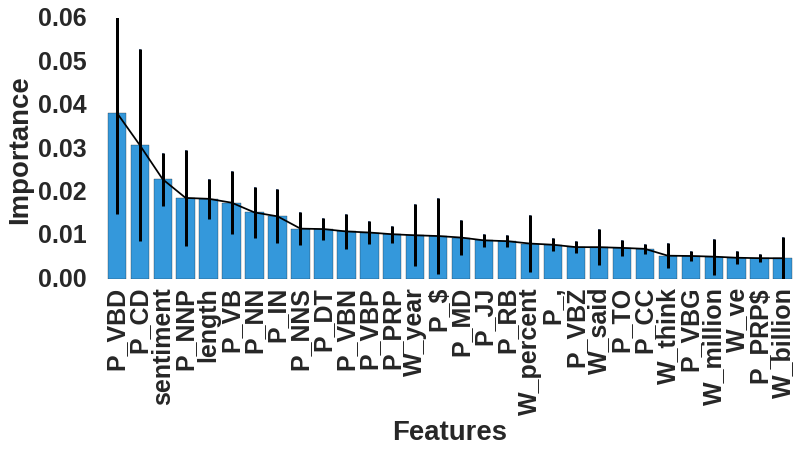

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(font_scale=2.5, color_codes=True)

fig, ax = plt.subplots(figsize=(12,7))
plt.xticks(rotation=90)
ax.grid(b=False)
ax.set_axis_bgcolor('white')

features = data_regex.columns

best_k = 30

plt.bar(range(best_k), importances[indices[0:best_k]], color="#3498db", yerr=std[indices[0:best_k]], align="center")

xticks = [tick.replace('_1', '') for tick in features[indices[0:best_k]]]
ax.set_ylim(0, 0.06)
plt.xticks(range(best_k), xticks)
plt.ylabel('Importance', weight = 'bold')
plt.xlabel('Features', weight = 'bold')
plt.xlim([-1, best_k])
plt.errorbar(range(best_k), importances[indices[0:best_k]], color="black", yerr=std[indices[0:best_k]], elinewidth=3)
plt.tight_layout()
plt.savefig('feature_importance.eps', format='eps', dpi=1200)